In [1]:
import cv2
import numpy as np
import random
import os
import matplotlib.pyplot as plt

# Functions of Use

#### Visualize Images

In [2]:
# Display images
def visualize_images(image_files, cols=3):
    """
    Visualizes a grid of images in Jupyter Lab.

    Parameters:
    ----------
    image_files : list
        List of image file paths to display.
    cols : int
        Number of columns in the grid.
    """
    rows = len(image_files) // cols + (len(image_files) % cols > 0)
    plt.figure(figsize=(15, 5 * rows))

    for i, image_file in enumerate(image_files):
        # Load image with OpenCV and convert to RGB
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Plot image
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(os.path.basename(image_file))
        plt.axis("off")

    plt.tight_layout()
    plt.show()



#### Acquires all images in a directory

In [3]:
def get_image_paths(directory):
    """
    Retrieves all image file paths from a specified directory.

    Parameters:
    ----------
    directory : str
        Path to the directory containing image files.

    Returns:
    -------
    list of str
        List of file paths for all images in the directory with supported extensions.
    """
    # Define supported image extensions
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

    # Collect all image paths with the correct extensions
    image_paths = [
        os.path.join(directory, f)
        for f in os.listdir(directory)
        if f.lower().endswith(image_extensions)
    ]
    
    # Sort paths for consistent processing order
    return sorted(image_paths)


#### Preprocess Images

This reads the image in grayscale, enhances contrast use CLAHE opencv package, applies gaussian blur to reduce background noise in image, applies Canny Edge detection. End result is us visualizing the edge detection

def preprocess_image(image_path, clip_limit=2.0, tile_grid_size=(8, 8), low_threshold=30, high_threshold=100):
    """
    Preprocesses the image with CLAHE for contrast enhancement before edge detection.

    Parameters:
    ----------
    image_path : str
        Path to the input image.
    clip_limit : float
        Threshold for contrast limiting in CLAHE.
    tile_grid_size : tuple
        Size of the grid for applying CLAHE.
    low_threshold : int
        Lower threshold for Canny edge detection.
    high_threshold : int
        Higher threshold for Canny edge detection.

    Returns:
    -------
    np.ndarray
        Edge-detected image.
    """
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    height, width = image.shape
    print('width of image is', width)
    print('height of image is', height)

    # Apply CLAHE for local contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced = clahe.apply(image)

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred, low_threshold, high_threshold)

    return edges


In [5]:
# Directory containing your images
image_directory = "/Users/sanuma/sanahbhim/MLnotebooks/DinoLiteImages/"

# Get all image paths from the directory
image_paths = get_image_paths(image_directory)

print(f"Found {len(image_paths)} images in {image_directory}")



Found 3 images in /Users/sanuma/sanahbhim/MLnotebooks/DinoLiteImages/


In [6]:
# Get a list of all image files in the directory
image_files = [
    os.path.join(image_directory, f)
    for f in sorted(os.listdir(image_directory))
    if f.endswith(('.png', '.jpg', '.jpeg'))
]

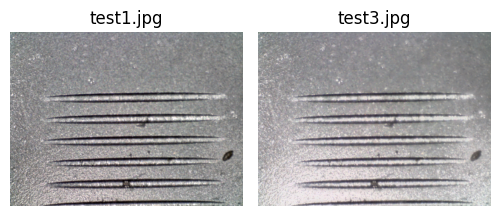

In [7]:
visualize_images(image_files, cols=6)

#### Detect Lines

Uses Hough Line Transform which does some kind of coordinate system transformation from cartesian (to polar I think) to detect lines. Commonly used method in image data analysis

In [8]:
def detect_lines(edges, width):
    """
    Detects straight lines using Hough Line Transform and ensures the longest horizontal line is selected.
    Prints the length of the longest line.

    Parameters:
    ----------
    edges : np.ndarray
        Edge-detected image.
    width : int
        Width of the input image.

    Returns:
    -------
    list of tuples
        Detected lines as (x1, y1, x2, y2).
    """
    # Use Hough Line Transform
    lines = cv2.HoughLinesP(
        edges,
        rho=1,  # Distance resolution in pixels
        theta=np.pi / 180,  # Angular resolution in radians
        threshold=50,  # Sensitivity to line detection
        minLineLength=width // 3,  # Minimum line length to detect
        maxLineGap=200,  # Further increase to allow merging of segments
    )

    if lines is not None:
        # Filter and prioritize horizontal lines
        horizontal_lines = []
        for [[x1, y1, x2, y2]] in lines:
            # Calculate angle of the line
            angle = abs(np.arctan2((y2 - y1), (x2 - x1)) * 180.0 / np.pi)
            if angle < 15:  # Filter nearly horizontal lines (angle < 15 degrees)
                length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                horizontal_lines.append((x1, y1, x2, y2, length))
        
        if horizontal_lines:
            # Sort horizontal lines by length in descending order
            horizontal_lines.sort(key=lambda line: line[4], reverse=True)
            # Get the longest line
            longest_line = horizontal_lines[0]
            line_length = longest_line[4]
            print(f"Longest line length: {line_length:.2f} pixels")
            # Return only the coordinates of the longest line
            return [(longest_line[0], longest_line[1], longest_line[2], longest_line[3])]
        else:
            print("No horizontal lines detected.")
            return []
    else:
        print("No lines detected.")
        return []


In [9]:
def visualize_detected_lines(image_path, edges, detected_cut):
    """
    Visualizes the original image, edge-detected image, and detected lines.

    Parameters:
    ----------
    image_path : str
        Path to the original image.
    edges : np.ndarray
        Edge-detected image.
    detected_cut : tuple
        A tuple containing:
        - Detected lines as (x1, y1, x2, y2).
        - The length of the detected cut in pixels.
    """
    # Unpack the detected cut
    lines, cut_length = detected_cut

    # Load the original image
    image = cv2.imread(image_path)
    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

    # Create a copy to draw lines
    image_with_lines = original_image.copy()

    # Draw detected lines
    if lines:
        for x1, y1, x2, y2 in lines:
            cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green lines

    # Visualize all three stages
    plt.figure(figsize=(20, 6))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    # Edge-Detected Image
    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap="gray")
    plt.title("Edge-Detected Image")
    plt.axis("off")

    # Image with Detected Lines
    plt.subplot(1, 3, 3)
    plt.imshow(image_with_lines)
    title_text = f"Detected Lines\nCut Length: {cut_length:.2f} pixels" if cut_length > 0 else "No Cut Detected"
    plt.title(title_text)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Edge Detection 

Don't need a hough line transform if the edge detection is working so well itself. Gather the coordinates from the edges and then determine those values in pixels and associate those pixel values i believe with mm length values measured

In [10]:
# Directory containing your images
image_directory = "/Users/sanuma/sanahbhim/MLnotebooks/DinoLiteImages/"

# Get all image paths from the directory
image_paths = get_image_paths(image_directory)

print(f"Found {len(image_paths)} images in {image_directory}")



Found 3 images in /Users/sanuma/sanahbhim/MLnotebooks/DinoLiteImages/


##### Trying a new detect lines function

In [11]:
def detect_cut_from_edges(edges, width, height):
    """
    Detects the cut made by the blade directly from the edge-detected image.
    Identifies the largest contiguous horizontal edge region and calculates its extent.

    Parameters:
    ----------
    edges : np.ndarray
        Edge-detected image.
    width : int
        Width of the input image.
    height : int
        Height of the input image.

    Returns:
    -------
    tuple
        - The start and end points of the detected cut as (x1, y1, x2, y2).
        - The length of the detected cut in pixels.
    """
    # Label connected components in the edge-detected image
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(edges, connectivity=8)

    # Find the largest connected component (excluding the background, which is label 0)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    # Create a mask for the largest connected component
    mask = (labels == largest_label).astype(np.uint8) * 255

    # Extract the x-coordinates of the non-zero pixels in the largest component
    y_indices, x_indices = np.where(mask > 0)

    if len(x_indices) > 0:
        # Find the start and end of the cut along the x-axis
        x_start, x_end = x_indices.min(), x_indices.max()

        # Fit a line or find the average y-coordinates for the cut
        y_start = int(np.median(y_indices[x_indices == x_start]))
        y_end = int(np.median(y_indices[x_indices == x_end]))

        # Calculate the length of the detected cut
        cut_length = np.sqrt((x_end - x_start) ** 2 + (y_end - y_start) ** 2)
        print(f"Cut length: {cut_length:.2f} pixels")

        return [(x_start, y_start, x_end, y_end)], cut_length
    else:
        print("No clear cut detected.")
        return [], 0


In [17]:
## jan 23 2026 (1 year later)
def detect_multiple_cuts_from_edges(edges, min_length_px=50, y_tol=10):
    """
    Detect multiple horizontal cuts from an edge image.

    Returns
    -------
    cuts : list of dicts
        Each dict contains:
        - x1, y1, x2, y2
        - length_px
    """
    ys, xs = np.where(edges > 0)

    # Sort by y
    order = np.argsort(ys)
    ys, xs = ys[order], xs[order]

    cuts = []
    current_xs = [xs[0]]
    current_ys = [ys[0]]

    for x, y in zip(xs[1:], ys[1:]):
        if abs(y - np.mean(current_ys)) <= y_tol:
            current_xs.append(x)
            current_ys.append(y)
        else:
            # finalize current cut
            x_min, x_max = min(current_xs), max(current_xs)
            length = x_max - x_min
            if length >= min_length_px:
                cuts.append({
                    "x1": x_min,
                    "y1": int(np.mean(current_ys)),
                    "x2": x_max,
                    "y2": int(np.mean(current_ys)),
                    "length_px": length
                })
            current_xs = [x]
            current_ys = [y]

    # final cut
    x_min, x_max = min(current_xs), max(current_xs)
    length = x_max - x_min
    if length >= min_length_px:
        cuts.append({
            "x1": x_min,
            "y1": int(np.mean(current_ys)),
            "x2": x_max,
            "y2": int(np.mean(current_ys)),
            "length_px": length
        })

    return cuts


In [16]:
def detect_raw_y_bands(edges, y_tol=5):
    """
    Group edge pixels into thin horizontal 'bands' by y proximity.
    This will over-segment (top/bottom edges, fragments), on purpose.
    """
    ys, xs = np.where(edges > 0)

    if len(xs) == 0:
        return []

    # Sort by y so we can scan top->bottom
    order = np.argsort(ys)
    ys, xs = ys[order], xs[order]

    bands = []
    current_xs = [int(xs[0])]
    current_ys = [int(ys[0])]

    for x, y in zip(xs[1:], ys[1:]):
        if abs(y - np.mean(current_ys)) <= y_tol:
            current_xs.append(int(x))
            current_ys.append(int(y))
        else:
            bands.append((current_xs, current_ys))
            current_xs = [int(x)]
            current_ys = [int(y)]

    bands.append((current_xs, current_ys))
    return bands


def merge_bands_into_cuts(bands, min_length_px=150, merge_y_tol=30):
    """
    Merge nearby y-bands into one physical cut (scratch).
    """
    if not bands:
        return []

    # Summarize each band as (y_mean, x_min, x_max, length)
    summaries = []
    for xs, ys in bands:
        x_min, x_max = min(xs), max(xs)
        length = x_max - x_min
        y_mean = float(np.mean(ys))
        if length >= min_length_px:
            summaries.append((y_mean, x_min, x_max, length))

    if not summaries:
        return []

    # Sort by y and merge close bands
    summaries.sort(key=lambda s: s[0])

    merged_groups = []
    current = [summaries[0]]

    for s in summaries[1:]:
        current_y = np.mean([c[0] for c in current])
        if abs(s[0] - current_y) <= merge_y_tol:
            current.append(s)
        else:
            merged_groups.append(current)
            current = [s]
    merged_groups.append(current)

    # Convert merged groups into final cuts
    cuts = []
    for group in merged_groups:
        y = int(np.mean([g[0] for g in group]))
        x1 = min(g[1] for g in group)
        x2 = max(g[2] for g in group)
        cuts.append({
            "x1": x1,
            "y1": y,
            "x2": x2,
            "y2": y,
            "length_px": float(x2 - x1),
        })

    return cuts


In [18]:
def visualize_detected_cuts(image_path, edges, cuts):
    image = cv2.imread(image_path)
    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_with_lines = original_image.copy()

    for cut in cuts:
        cv2.line(
            image_with_lines,
            (cut["x1"], cut["y1"]),
            (cut["x2"], cut["y2"]),
            (0, 255, 0),
            2,
        )

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap="gray")
    plt.title("Edge-Detected Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(image_with_lines)
    plt.title(f"Detected Cuts: {len(cuts)}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [21]:
def preprocess_image(
    image_path,
    clip_limit=2.0,
    tile_grid_size=(8, 8),
    low_threshold=40,
    high_threshold=120,
    blur_ksize=5,
    blackhat_ksize=31,
):
    """
    Preprocess for scratch-like dark horizontal cuts on bright textured background.
    Uses CLAHE + black-hat (background removal) + blur + Canny.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # 1) CLAHE (moderate)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced = clahe.apply(image)

    # 2) Black-hat to emphasize dark thin features (scratches) on bright background
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (blackhat_ksize, blackhat_ksize))
    blackhat = cv2.morphologyEx(enhanced, cv2.MORPH_BLACKHAT, kernel)

    # 3) Blur to suppress speckle noise
    blurred = cv2.GaussianBlur(blackhat, (blur_ksize, blur_ksize), 0)

    # 4) Canny on the cleaned-up image
    edges = cv2.Canny(blurred, low_threshold, high_threshold)

    return edges, blackhat, blurred


In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def preprocess_image_blackhat(
    image_path,
    clip_limit=2.0,
    tile_grid_size=(8, 8),
    blackhat_ksize=51,
    blur_ksize=5,
):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced = clahe.apply(img)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (blackhat_ksize, blackhat_ksize))
    blackhat = cv2.morphologyEx(enhanced, cv2.MORPH_BLACKHAT, kernel)

    blurred = cv2.GaussianBlur(blackhat, (blur_ksize, blur_ksize), 0)

    return img, blackhat, blurred

def extract_horizontal_mask(blurred_blackhat, binarize="otsu", open_len=250, close_len=120):
    """
    Turn blackhat into a binary mask of long horizontal features (scratches).
    """
    # --- Binarize ---
    if binarize == "otsu":
        # Otsu chooses threshold automatically
        _, bw = cv2.threshold(blurred_blackhat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        # fallback fixed threshold
        _, bw = cv2.threshold(blurred_blackhat, 30, 255, cv2.THRESH_BINARY)

    # --- Morphology to keep long horizontals and kill speckle ---
    # Opening removes small junk but preserves long horizontal structures
    open_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (open_len, 3))
    bw_open = cv2.morphologyEx(bw, cv2.MORPH_OPEN, open_kernel)

    # Closing reconnects broken segments along the horizontal direction
    close_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (close_len, 3))
    bw_clean = cv2.morphologyEx(bw_open, cv2.MORPH_CLOSE, close_kernel)

    return bw, bw_clean


def detect_cuts_from_mask(mask, min_width_px=600, max_height_px=80, min_area=2000):
    """
    Find connected components in the horizontal mask and measure each as a cut.
    Returns a list of cuts with x1,y1,x2,y2,length_px.
    """
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

    cuts = []
    for lab in range(1, num_labels):  # skip background=0
        x, y, w, h, area = stats[lab]

        # Filter for "scratch-like" components
        if w < min_width_px:
            continue
        if h > max_height_px:
            continue
        if area < min_area:
            continue

        y_mid = int(y + h / 2)
        cuts.append({
            "x1": int(x),
            "y1": y_mid,
            "x2": int(x + w),
            "y2": y_mid,
            "length_px": float(w),
            "bbox": (int(x), int(y), int(w), int(h)),
            "area": int(area),
        })

    # Sort top-to-bottom
    cuts.sort(key=lambda c: c["y1"])
    return cuts



def visualize_mask_and_cuts(image_path, blackhat, bw_raw, bw_clean, cuts):
    img = cv2.imread(image_path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    overlay = rgb.copy()

    # draw bbox + centerline for each cut
    for c in cuts:
        x, y, w, h = c["bbox"]
        cv2.rectangle(overlay, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.line(overlay, (c["x1"], c["y1"]), (c["x2"], c["y2"]), (0, 255, 0), 2)

    plt.figure(figsize=(22, 10))
    plt.subplot(2,2,1); plt.imshow(blackhat, cmap="gray"); plt.title("Blackhat"); plt.axis("off")
    plt.subplot(2,2,2); plt.imshow(bw_raw, cmap="gray"); plt.title("Binary (raw)"); plt.axis("off")
    plt.subplot(2,2,3); plt.imshow(bw_clean, cmap="gray"); plt.title("Binary (horizontal-cleaned)"); plt.axis("off")
    plt.subplot(2,2,4); plt.imshow(overlay); plt.title(f"Detected cuts: {len(cuts)}"); plt.axis("off")
    plt.tight_layout()
    plt.show()


In [52]:
def find_cut_bands_from_mask(mask, min_run=12, min_gap=18, min_row_sum=200):
    """
    Find horizontal bands (y-ranges) where the mask has lots of white pixels.
    Returns list of (y0, y1) inclusive bounds for each band.
    """
    # mask is 0/255; convert to 0/1 then sum across x
    row_sum = (mask > 0).sum(axis=1)

    bands = []
    in_band = False
    start = 0

    for y, s in enumerate(row_sum):
        if (s >= min_row_sum) and (not in_band):
            in_band = True
            start = y
        elif (s < min_row_sum) and in_band:
            end = y - 1
            if (end - start + 1) >= min_run:
                bands.append([start, end])
            in_band = False

    # close if ended inside a band
    if in_band:
        end = len(row_sum) - 1
        if (end - start + 1) >= min_run:
            bands.append([start, end])

    # merge bands separated by small gaps (multiple ridges within one physical cut)
    merged = []
    for b in bands:
        if not merged:
            merged.append(b)
        else:
            if b[0] - merged[-1][1] <= min_gap:
                merged[-1][1] = b[1]
            else:
                merged.append(b)

    return [(b[0], b[1]) for b in merged]


def measure_cuts_from_bands(mask, bands, min_width_px=600):
    """
    For each y-band, measure x extent using all mask pixels within that band.
    Returns cuts list with x1,y1,x2,y2,length_px and band.
    """
    cuts = []
    H, W = mask.shape

    for (y0, y1) in bands:
        band = mask[y0:y1+1, :]
        ys, xs = np.where(band > 0)

        if len(xs) == 0:
            continue

        x1, x2 = int(xs.min()), int(xs.max())
        length = x2 - x1

        if length < min_width_px:
            continue

        y_mid = int((y0 + y1) / 2)
        cuts.append({
            "x1": x1,
            "y1": y_mid,
            "x2": x2,
            "y2": y_mid,
            "length_px": float(length),
            "band": (int(y0), int(y1))
        })

    cuts.sort(key=lambda c: c["y1"])
    return cuts

def visualize_bands_and_cuts(image_path, bw_clean, cuts):
    img = cv2.imread(image_path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    overlay = rgb.copy()

    for c in cuts:
        y0, y1 = c["band"]
        # band box
        cv2.rectangle(overlay, (0, y0), (rgb.shape[1]-1, y1), (0, 0, 255), 2)
        # measured cut line
        cv2.line(overlay, (c["x1"], c["y1"]), (c["x2"], c["y2"]), (0, 255, 0), 2)

    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1); plt.imshow(bw_clean, cmap="gray"); plt.title("Binary (horizontal-cleaned)"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title(f"Cuts: {len(cuts)}"); plt.axis("off")
    plt.tight_layout()
    plt.show()

def merge_bands_by_x_overlap(mask, bands, gap_tol=80, overlap_frac=0.6):
    """
    Merge adjacent bands if they are close in y AND their x support overlaps strongly.
    """
    if not bands:
        return []

    def x_extent(y0, y1):
        band = mask[y0:y1+1, :]
        ys, xs = np.where(band > 0)
        if len(xs) == 0:
            return None
        return int(xs.min()), int(xs.max())

    merged = [list(bands[0])]
    for (y0, y1) in bands[1:]:
        prev_y0, prev_y1 = merged[-1]
        if y0 - prev_y1 > gap_tol:
            merged.append([y0, y1])
            continue

        prev_ext = x_extent(prev_y0, prev_y1)
        cur_ext  = x_extent(y0, y1)
        if (prev_ext is None) or (cur_ext is None):
            merged.append([y0, y1])
            continue

        px1, px2 = prev_ext
        cx1, cx2 = cur_ext

        # overlap length / smaller length
        overlap = max(0, min(px2, cx2) - max(px1, cx1))
        denom = max(1, min(px2 - px1, cx2 - cx1))
        frac = overlap / denom

        if frac >= overlap_frac:
            merged[-1][1] = y1   # merge
        else:
            merged.append([y0, y1])

    return [(a, b) for a, b in merged]



Bands found (pre-merge): 6
Bands found (post-merge): 6
Final cuts: 6
  Cut 0: 1859.0 px, band=(683, 794)
  Cut 1: 1856.0 px, band=(921, 1032)
  Cut 2: 1981.0 px, band=(1165, 1277)
  Cut 3: 1878.0 px, band=(1402, 1511)
  Cut 4: 1909.0 px, band=(1641, 1751)
  Cut 5: 1986.0 px, band=(1881, 1932)


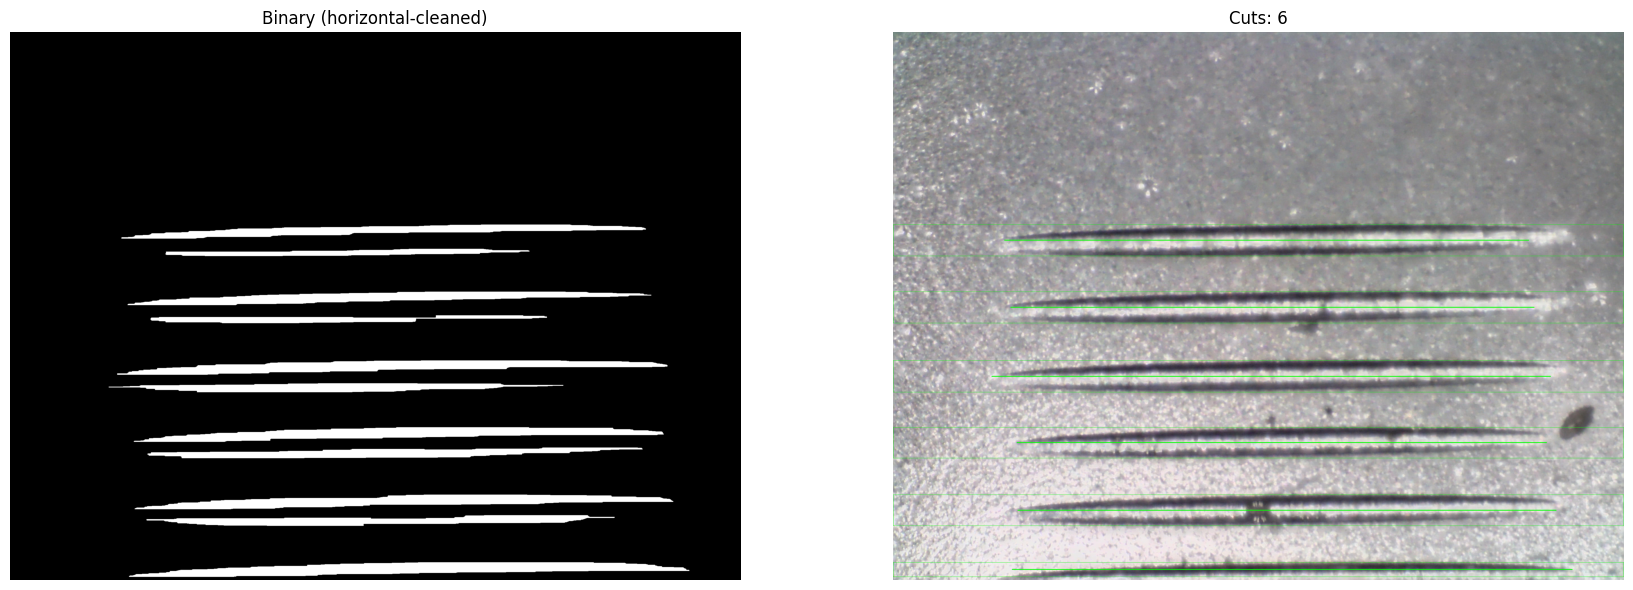

In [35]:
image_path = "/Users/sanuma/sanahbhim/MLnotebooks/DinoLiteImages/test3.jpg"

# 1) preprocess
orig, blackhat, blurred = preprocess_image_blackhat(
    image_path,
    clip_limit=2.0,
    blackhat_ksize=51,
    blur_ksize=5
)

# 2) extract horizontal-only binary mask
bw_raw, bw_clean = extract_horizontal_mask(
    blurred,
    binarize="otsu",
    open_len=250,
    close_len=120
)

# 3) find initial bands from y-projection
bands = find_cut_bands_from_mask(
    bw_clean,
    min_run=10,
    min_gap=80,
    min_row_sum=150
)

# 4) merge adjacent bands that overlap in x (collapses double ridges per cut)
bands_merged = merge_bands_by_x_overlap(
    bw_clean,
    bands,
    gap_tol=80,         # should match your min_gap-ish scale
    overlap_frac=0.6    # higher = stricter merging; lower = more merging
)

# 5) measure cuts from merged bands
cuts = measure_cuts_from_bands(
    bw_clean,
    bands_merged,
    min_width_px=800
)

print(f"Bands found (pre-merge): {len(bands)}")
print(f"Bands found (post-merge): {len(bands_merged)}")
print(f"Final cuts: {len(cuts)}")
for i, c in enumerate(cuts):
    print(f"  Cut {i}: {c['length_px']:.1f} px, band={c['band']}")

# visualize
visualize_bands_and_cuts(image_path, bw_clean, cuts)


Bands found (pre-merge): 6
Bands found (post-merge): 6
Final cuts: 6
  Cut 0: 2206.0 px, band=(438, 559)
  Cut 1: 2226.0 px, band=(705, 825)
  Cut 2: 2251.0 px, band=(979, 1097)
  Cut 3: 2117.0 px, band=(1247, 1362)
  Cut 4: 2216.0 px, band=(1520, 1633)
  Cut 5: 2288.0 px, band=(1792, 1904)


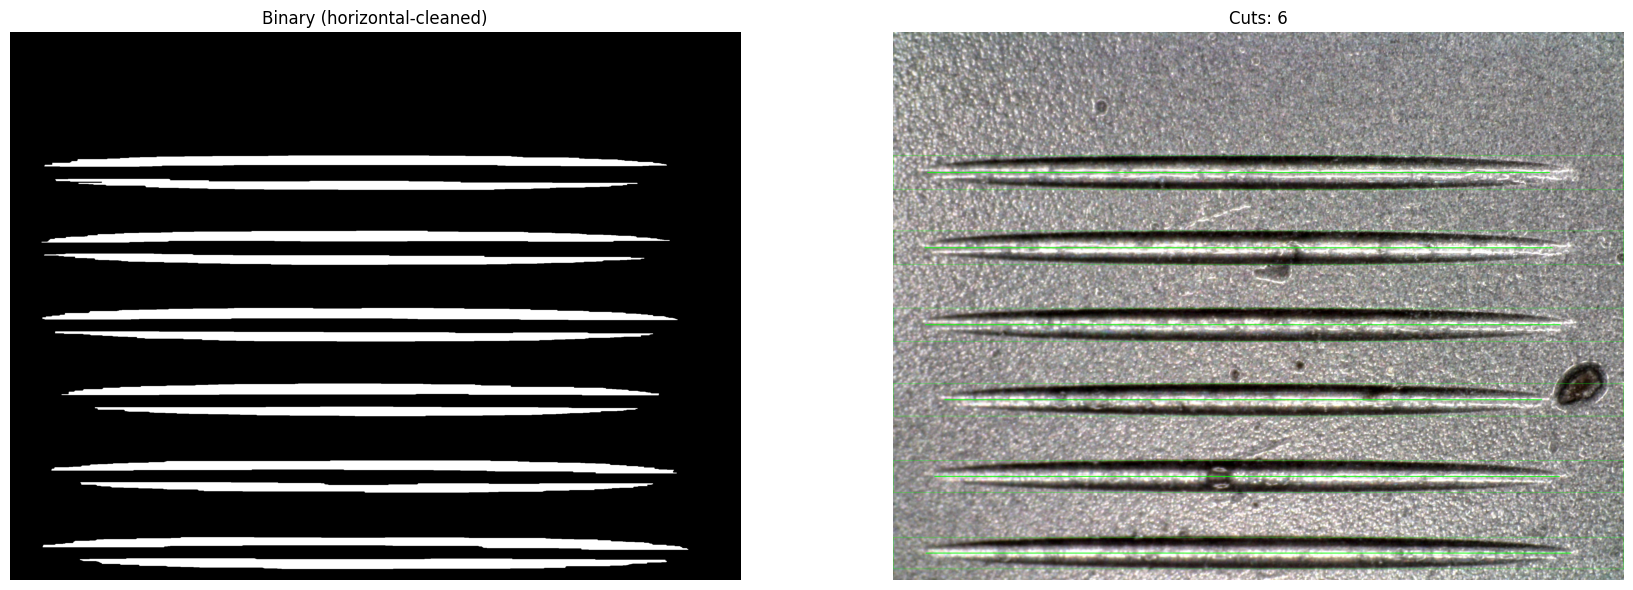

In [36]:
image_path = "/Users/sanuma/sanahbhim/MLnotebooks/DinoLiteImages/test4_EDRused.jpg"

# 1) preprocess
orig, blackhat, blurred = preprocess_image_blackhat(
    image_path,
    clip_limit=2.0,
    blackhat_ksize=51,
    blur_ksize=5
)

# 2) extract horizontal-only binary mask
bw_raw, bw_clean = extract_horizontal_mask(
    blurred,
    binarize="otsu",
    open_len=250,
    close_len=120
)

# 3) find initial bands from y-projection
bands = find_cut_bands_from_mask(
    bw_clean,
    min_run=10,
    min_gap=80,
    min_row_sum=150
)

# 4) merge adjacent bands that overlap in x (collapses double ridges per cut)
bands_merged = merge_bands_by_x_overlap(
    bw_clean,
    bands,
    gap_tol=80,         # should match your min_gap-ish scale
    overlap_frac=0.6    # higher = stricter merging; lower = more merging
)

# 5) measure cuts from merged bands
cuts = measure_cuts_from_bands(
    bw_clean,
    bands_merged,
    min_width_px=800
)

print(f"Bands found (pre-merge): {len(bands)}")
print(f"Bands found (post-merge): {len(bands_merged)}")
print(f"Final cuts: {len(cuts)}")
for i, c in enumerate(cuts):
    print(f"  Cut {i}: {c['length_px']:.1f} px, band={c['band']}")

# visualize
visualize_bands_and_cuts(image_path, bw_clean, cuts)


Bands found (pre-merge): 6
Bands found (post-merge): 6
Final cuts: 6
  Cut 0: 1962.0 px, band=(457, 570)
  Cut 1: 2004.0 px, band=(708, 820)
  Cut 2: 2052.0 px, band=(966, 1079)
  Cut 3: 1916.0 px, band=(1218, 1327)
  Cut 4: 2006.0 px, band=(1474, 1582)
  Cut 5: 2132.0 px, band=(1729, 1838)


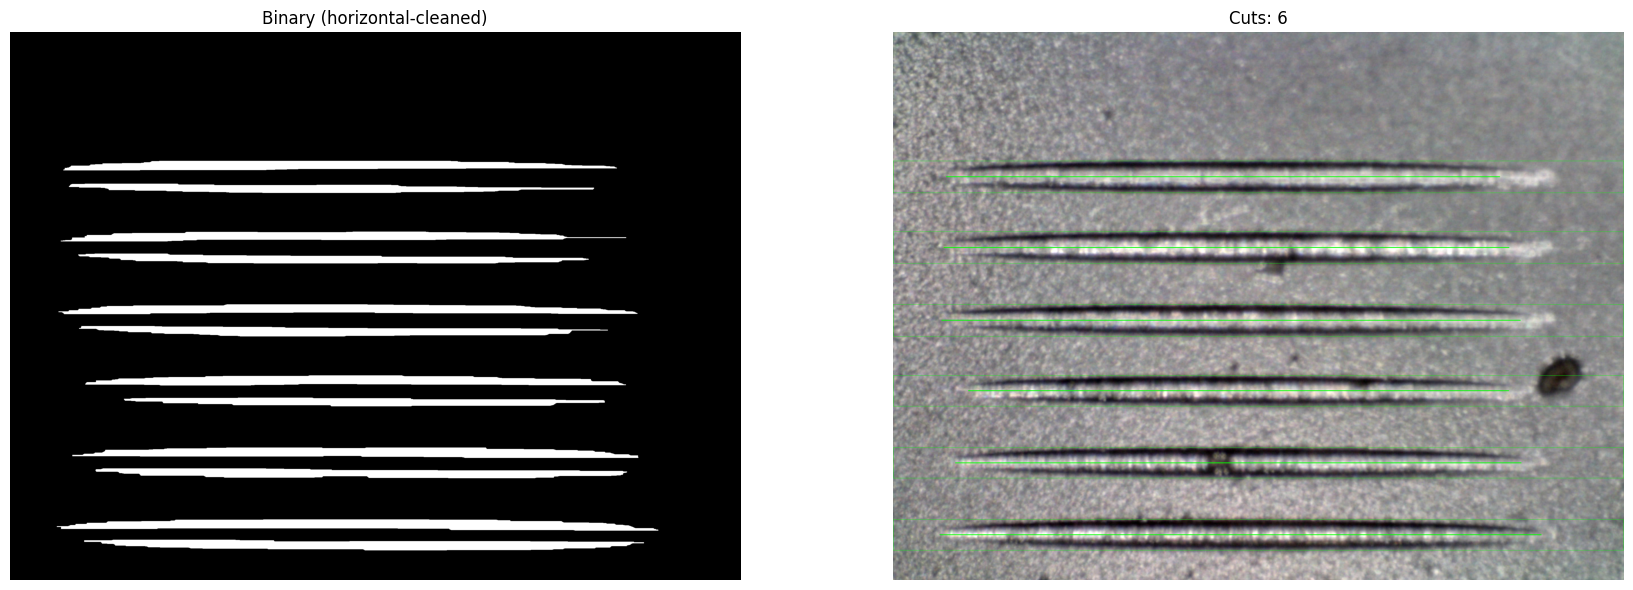

In [37]:

image_path = "/Users/sanuma/sanahbhim/MLnotebooks/DinoLiteImages/test5_76x_EDR.jpg"

# 1) preprocess
orig, blackhat, blurred = preprocess_image_blackhat(
    image_path,
    clip_limit=2.0,
    blackhat_ksize=51,
    blur_ksize=5
)

# 2) extract horizontal-only binary mask
bw_raw, bw_clean = extract_horizontal_mask(
    blurred,
    binarize="otsu",
    open_len=250,
    close_len=120
)

# 3) find initial bands from y-projection
bands = find_cut_bands_from_mask(
    bw_clean,
    min_run=10,
    min_gap=80,
    min_row_sum=150
)

# 4) merge adjacent bands that overlap in x (collapses double ridges per cut)
bands_merged = merge_bands_by_x_overlap(
    bw_clean,
    bands,
    gap_tol=80,         # should match your min_gap-ish scale
    overlap_frac=0.6    # higher = stricter merging; lower = more merging
)

# 5) measure cuts from merged bands
cuts = measure_cuts_from_bands(
    bw_clean,
    bands_merged,
    min_width_px=800
)

print(f"Bands found (pre-merge): {len(bands)}")
print(f"Bands found (post-merge): {len(bands_merged)}")
print(f"Final cuts: {len(cuts)}")
for i, c in enumerate(cuts):
    print(f"  Cut {i}: {c['length_px']:.1f} px, band={c['band']}")

# visualize
visualize_bands_and_cuts(image_path, bw_clean, cuts)


In [38]:
mm_per_pixel = 4.974 / width
print(mm_per_pixel)


0.0019189814814814816


In [40]:
def convert_cuts_px_to_mm(cuts, fov_width_mm, image_width_px):
    """
    Convert cut lengths from pixels to millimeters.

    Parameters
    ----------
    cuts : list of dict
        Output from cut detection, each dict must contain 'length_px'.
    fov_width_mm : float
        Physical width of the image in millimeters (from Dino-Lite).
    image_width_px : int
        Width of the image in pixels.

    Returns
    -------
    list of dict
        Same cuts with an added 'length_mm' field.
    """
    mm_per_pixel = fov_width_mm / image_width_px

    cuts_mm = []
    for c in cuts:
        c_mm = c.copy()
        c_mm["length_mm"] = c["length_px"] * mm_per_pixel
        cuts_mm.append(c_mm)

    return cuts_mm


In [41]:
cuts_mm = convert_cuts_px_to_mm(
    cuts,
    fov_width_mm=4.974,
    image_width_px=2592
)

for i, c in enumerate(cuts_mm):
    print(f"Cut {i}: {c['length_px']:.1f} px  →  {c['length_mm']:.3f} mm")


Cut 0: 1962.0 px  →  3.765 mm
Cut 1: 2004.0 px  →  3.846 mm
Cut 2: 2052.0 px  →  3.938 mm
Cut 3: 1916.0 px  →  3.677 mm
Cut 4: 2006.0 px  →  3.849 mm
Cut 5: 2132.0 px  →  4.091 mm


##### the above is making the right most x not as matched up to the edge so need to find a better way to do this (this occurs pretty consistently no matter the resolution of the microscope)

In [47]:
def x_extent_from_band_profile_gated(
    blackhat, bw_clean, y0, y1,
    pad_y=6,
    frac=0.35,          # higher than before because we’re now gated
    gap_fill_px=60,
    min_span_px=200,
    min_support_rows=3  # require >= this many rows support at that x
):
    """
    Estimate (x1, x2) inside a y-band using a blackhat x-profile,
    but ONLY where bw_clean says “there is a horizontal feature”.
    Prevents background texture from extending to image borders.
    """
    H, W = blackhat.shape
    yy0 = max(0, y0 - pad_y)
    yy1 = min(H - 1, y1 + pad_y)

    bh_patch = blackhat[yy0:yy1+1, :]
    bw_patch = (bw_clean[yy0:yy1+1, :] > 0).astype(np.uint8)

    # Gate blackhat by the binary mask (only measure where mask is white)
    gated = bh_patch * bw_patch

    # 1D profile: strength vs x, but only in masked regions
    prof = gated.max(axis=0).astype(np.float32)

    # Also require that the mask actually has support in x (avoid single speckles)
    support = bw_patch.sum(axis=0)  # how many rows are “on” at each x
    support_ok = support >= min_support_rows

    # Adaptive threshold relative to gated signal
    peak = float(prof.max())
    if peak <= 0:
        return None

    t = frac * peak
    bw1d = ((prof >= t) & support_ok).astype(np.uint8)

    # Fill small gaps
    k = max(3, int(gap_fill_px) | 1)
    kernel = np.ones((k,), np.uint8)
    bw1d_closed = cv2.morphologyEx(bw1d.reshape(1, -1), cv2.MORPH_CLOSE, kernel).ravel()

    xs = np.where(bw1d_closed > 0)[0]
    if len(xs) == 0:
        return None

    x1, x2 = int(xs.min()), int(xs.max())
    if (x2 - x1) < min_span_px:
        return None

    return x1, x2

def measure_cuts_from_bands_profile(
    blackhat, bw_clean, bands,
    fov_width_mm, image_width_px,
    min_width_px=800,
    pad_y=6,
    frac=0.35,
    gap_fill_px=60
):
    mm_per_pixel = fov_width_mm / image_width_px
    cuts = []

    for (y0, y1) in bands:
        ext = x_extent_from_band_profile_gated(
            blackhat, bw_clean, y0, y1,
            pad_y=pad_y,
            frac=frac,
            gap_fill_px=gap_fill_px
        )
        if ext is None:
            continue

        x1, x2 = ext
        length_px = x2 - x1
        if length_px < min_width_px:
            continue

        y_mid = int((y0 + y1) / 2)
        cuts.append({
            "x1": x1, "y1": y_mid,
            "x2": x2, "y2": y_mid,
            "length_px": float(length_px),
            "length_mm": float(length_px * mm_per_pixel),
            "band": (int(y0), int(y1))
        })

    cuts.sort(key=lambda c: c["y1"])
    return cuts


Cut 0: 2077.0 px  →  3.986 mm
Cut 1: 2073.0 px  →  3.978 mm
Cut 2: 2119.0 px  →  4.066 mm
Cut 3: 2008.0 px  →  3.853 mm
Cut 4: 2095.0 px  →  4.020 mm
Cut 5: 2252.0 px  →  4.322 mm


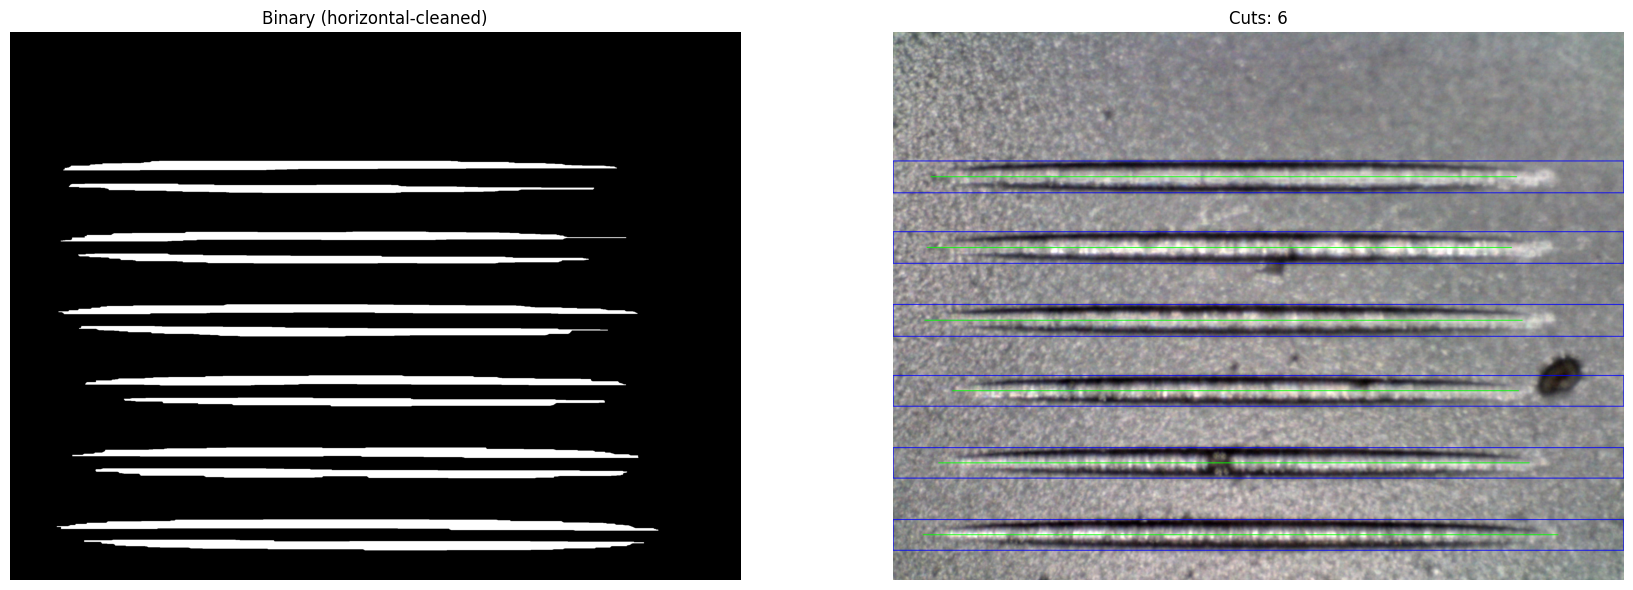

In [53]:
import cv2
import numpy as np

image_path = "/Users/sanuma/sanahbhim/MLnotebooks/DinoLiteImages/test5_76x_EDR.jpg"

# 1) preprocess
orig, blackhat, blurred = preprocess_image_blackhat(
    image_path,
    clip_limit=2.0,
    blackhat_ksize=51,
    blur_ksize=5
)

# 2) extract horizontal-only binary mask (STRICT mask for band finding)
bw_raw, bw_clean = extract_horizontal_mask(
    blurred,
    binarize="otsu",
    open_len=250,
    close_len=120
)

# 2b) Loosen mask in X so faint tails are included during measurement
bw_gate = cv2.dilate(
    (bw_clean > 0).astype(np.uint8) * 255,
    cv2.getStructuringElement(cv2.MORPH_RECT, (121, 5)),
    iterations=1
)

# 3) find bands from the STRICT mask
bands = find_cut_bands_from_mask(
    bw_clean,
    min_run=10,
    min_gap=80,
    min_row_sum=150
)

# 4) merge adjacent bands (still use strict mask here)
bands_merged = merge_bands_by_x_overlap(
    bw_clean,
    bands,
    gap_tol=80,
    overlap_frac=0.6
)

# 5) measure x-extents using the LOOSE gate
cuts = measure_cuts_from_bands_profile(
    blackhat,
    bw_gate,             # <-- use bw_gate here
    bands_merged,
    fov_width_mm=4.974,
    image_width_px=2592,
    min_width_px=800,
    pad_y=8,
    frac=0.30,           # start a bit lower now that the gate is larger
    gap_fill_px=120
)

for i, c in enumerate(cuts):
    print(f"Cut {i}: {c['length_px']:.1f} px  →  {c['length_mm']:.3f} mm")

# visualize (keep showing bw_clean so you see the strict segmentation)
visualize_bands_and_cuts(image_path, bw_clean, cuts)


In [62]:
## tryingto improve the above with the first couple cuts not catching the right edge but the later cuts do 
## and that just doesn't really make any sense

import numpy as np
import cv2

def measure_cuts_from_bands_mask_energy(gate, bands, *,
                                       fov_width_mm, image_width_px,
                                       pad_y=8, min_width_px=800,
                                       energy_frac=0.995,   # higher is fine for binary
                                       smooth_px=31,
                                       gap_fill_px=160):
    """
    Measure x-extent from a binary gate mask using cumulative 'area' energy.
    Much more stable than using blackhat intensity when background texture is strong.
    """
    mm_per_px = fov_width_mm / image_width_px
    cuts = []

    gate01 = (gate > 0).astype(np.uint8)
    H, W = gate01.shape

    k = max(3, smooth_px | 1)
    kernel = np.ones(k, dtype=np.float32) / k

    for (y0, y1) in bands:
        ya = max(0, y0 - pad_y)
        yb = min(H, y1 + pad_y)

        roi = gate01[ya:yb, :]

        # x-profile = how many white pixels in each column
        prof = roi.sum(axis=0).astype(np.float32)

        # smooth
        prof_s = np.convolve(prof, kernel, mode="same")

        total = prof_s.sum()
        if total <= 0:
            continue

        # Fill small gaps in x support
        support = (prof_s > 0).astype(np.uint8)
        if gap_fill_px and gap_fill_px > 1:
            support = cv2.dilate(
                support.reshape(1, -1),
                cv2.getStructuringElement(cv2.MORPH_RECT, (gap_fill_px, 1)),
                iterations=1
            ).ravel()
            prof_s = prof_s * support

        cdf = np.cumsum(prof_s)
        left_idx  = int(np.searchsorted(cdf, (1 - energy_frac) * total))
        right_idx = int(np.searchsorted(cdf, energy_frac * total))

        x1 = max(0, min(W - 1, left_idx))
        x2 = max(0, min(W - 1, right_idx))
        length_px = float(max(0, x2 - x1))

        if length_px < min_width_px:
            continue

        y_mid = int((y0 + y1) / 2)
        cuts.append({
            "x1": x1, "y1": y_mid,
            "x2": x2, "y2": y_mid,
            "length_px": length_px,
            "length_mm": length_px * mm_per_px,
            "band": (y0, y1),
        })

    return cuts



def visualize_bands_and_cuts(image_path, bw_clean, cuts):
    img = cv2.imread(image_path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    overlay = rgb.copy()

    for c in cuts:
        y0, y1 = c["band"]
        # band box
        cv2.rectangle(overlay, (0, y0), (rgb.shape[1]-1, y1), (0, 0, 255), 3)
        # measured cut line
        cv2.line(overlay, (c["x1"], c["y1"]), (c["x2"], c["y2"]), (0, 255, 0), 4)

    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1); plt.imshow(bw_clean, cmap="gray"); plt.title("Binary (horizontal-cleaned)"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title(f"Cuts: {len(cuts)}"); plt.axis("off")
    plt.tight_layout()
    plt.show()


Cut 0: 2111.0 px  →  4.051 mm
Cut 1: 2072.0 px  →  3.976 mm
Cut 2: 2181.0 px  →  4.185 mm
Cut 3: 2060.0 px  →  3.953 mm
Cut 4: 2127.0 px  →  4.082 mm
Cut 5: 2246.0 px  →  4.310 mm


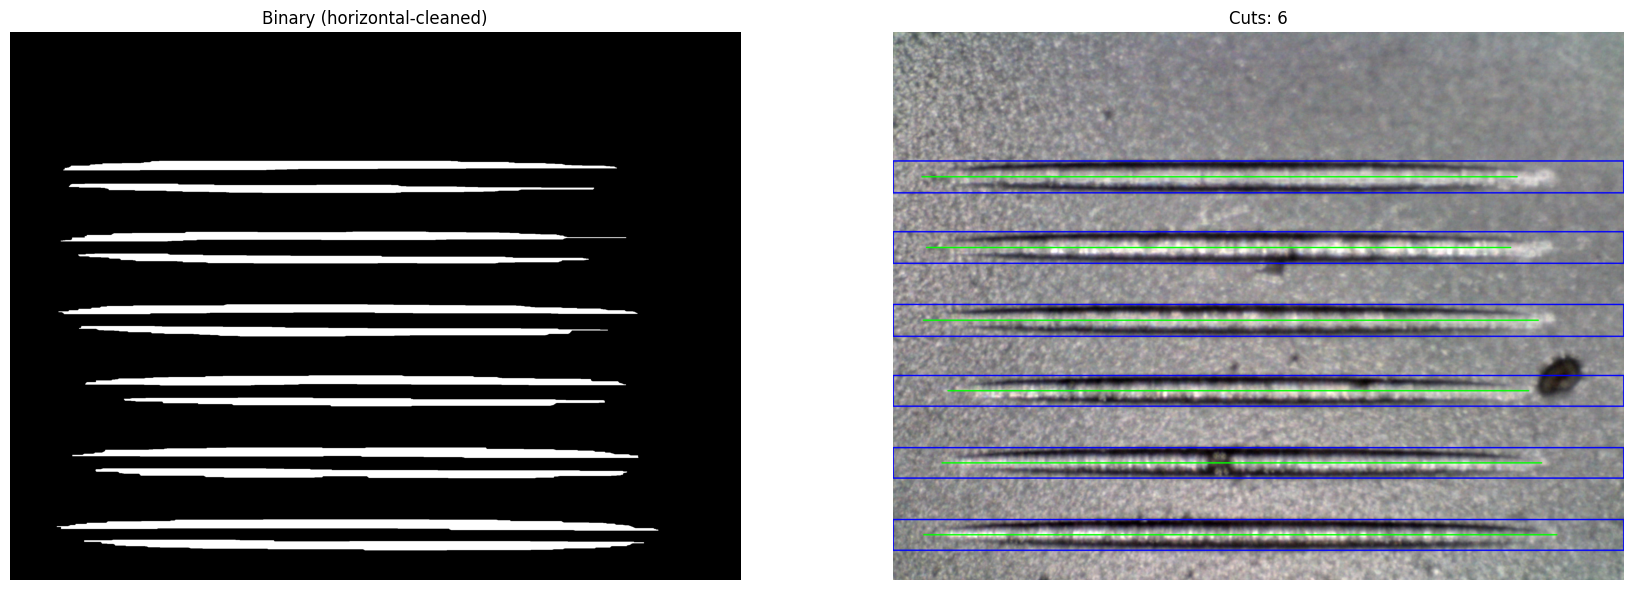

In [63]:
import cv2
import numpy as np

image_path = "/Users/sanuma/sanahbhim/MLnotebooks/DinoLiteImages/test5_76x_EDR.jpg"

orig, blackhat, blurred = preprocess_image_blackhat(
    image_path,
    clip_limit=2.0,
    blackhat_ksize=51,
    blur_ksize=5
)

bw_raw, bw_clean = extract_horizontal_mask(
    blurred,
    binarize="otsu",
    open_len=250,
    close_len=120
)

# Gate: widen in X, but KEEP Y VERY TIGHT
bw_gate = cv2.dilate(
    (bw_clean > 0).astype(np.uint8) * 255,
    cv2.getStructuringElement(cv2.MORPH_RECT, (241, 3)),  # <-- changed (X bigger, Y smaller)
    iterations=1
)

bands = find_cut_bands_from_mask(
    bw_clean,
    min_run=10,
    min_gap=80,
    min_row_sum=150
)

bands_merged = merge_bands_by_x_overlap(
    bw_clean,
    bands,
    gap_tol=80,
    overlap_frac=0.6
)

cuts = measure_cuts_from_bands_mask_energy(
    bw_gate,
    bands_merged,
    fov_width_mm=4.974,
    image_width_px=2592,
    pad_y=8,
    min_width_px=800,
    energy_frac=0.995,   # binary -> use higher
    smooth_px=31,
    gap_fill_px=260
)

for i, c in enumerate(cuts):
    print(f"Cut {i}: {c['length_px']:.1f} px  →  {c['length_mm']:.3f} mm")

visualize_bands_and_cuts(image_path, bw_clean, cuts)


In [ ]:

### after talking to Rahul about to-dos
## add conditions for being within certain y bounds
## the last line should show up at the same general range in y since we 
## should be moving the same distance each time we go for a measurement

### Data Manipulation for ML Step

In [ ]:
# Detected lengths in pixels
cut_lengths_pixels = np.array([278, 260, 245, 230, 210, 190, 185, 185, 180, 170])

# Corresponding measured lengths in mm
cut_lengths_mm = np.array([4, 3.8, 3.6, 3.4, 3.1, 2.8, 2.8, 2.8, 2.8, 2.6])

# Reshape for sklearn
X = cut_lengths_pixels.reshape(-1, 1)  # Features (in pixels)
y = cut_lengths_mm  # Targets (in mm)


# Machine Learning

#### Define the Train-Test Split

Here, we're using 80% of data for training and 20% for testing

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Train the Linear Regression Model

In [ ]:
## train the linear regression model
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)


#### Evaluate Linear Regression Model

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


#### Visualize the Results

In [ ]:
import matplotlib.pyplot as plt

# Plot the training data and the regression line
plt.scatter(X_train, y_train, color='blue', label='Training data')
plt.scatter(X_test, y_test, color='red', label='Test data')
plt.plot(X, model.predict(X), color='green', label='Regression line')

plt.xlabel("Cut Lengths (Pixels)")
plt.ylabel("Cut Lengths (mm)")
plt.title("Linear Regression: Pixels vs mm")
plt.legend()
plt.show()


#### Make Predictions Using the Trained Model

In [ ]:
# Example new pixel length
new_pixel_length = np.array([[215]])  # Replace with actual value
predicted_mm = model.predict(new_pixel_length)
print(f"Predicted cut length (mm) for {new_pixel_length[0][0]} pixels: {predicted_mm[0]:.2f} mm")


# The Full ML Pipeline (Linear Regression)

In [ ]:
# Train-Test Split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate model performance
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print evaluation metrics
print(f"Training MSE: {mse_train:.4f}, R²: {r2_train:.4f}")
print(f"Testing MSE: {mse_test:.4f}, R²: {r2_test:.4f}\n")

# Print True vs. Predicted Values
print("Training Data: True vs Predicted")
for true, pred in zip(y_train, y_train_pred):
    print(f"True: {true:.2f} mm, Predicted: {pred:.2f} mm")

print("\nTesting Data: True vs Predicted")
for true, pred in zip(y_test, y_test_pred):
    print(f"True: {true:.2f} mm, Predicted: {pred:.2f} mm")


# Adding in Rahul's Images

In [ ]:
# Directory containing your images
image_directory = "/Users/sanuma/Desktop/Jan10MicroscopePhotos/RahulImages/column1/"

# Get all image paths from the directory
image_paths = get_image_paths(image_directory)

print(f"Found {len(image_paths)} images in {image_directory}")



In [ ]:
cut_lengths_mm_rahul = [3.62, 3.62, 3.63, 3.63, 4.01]

##### First, I'm curious as to what the current ML algorithm would predict are the values of these cuts using Linear Regression

So that requires doing the preprocessing and then saving the pixels for them; let's see how well they do

In [ ]:
# Process all images in the directory
width = 480
height = 640



cut_lengths_pixels = []
for image_path in image_paths:
    print(f"Processing: {image_path}")
    edges = preprocess_image(image_path, clip_limit=0.2, tile_grid_size=(8, 8), low_threshold=80, high_threshold=200)
    detected_cut = detect_cut_from_edges(edges, width, height)  # Returns (lines, cut_length)
    lines, cut_length = detected_cut  # Unpack the tuple
    cut_lengths_pixels.append(cut_length)
    print(f"Detected {len(lines)} lines")
    visualize_detected_lines(image_path, edges, detected_cut)
 # Pass only the lines


In [ ]:
import os

# Filter image paths to exclude files with '_fix' in the name
filtered_image_paths = [path for path in image_paths if '_fix' not in os.path.basename(path)]

# Initialize arrays to store pixel and mm values
cut_lengths_pixels_new = []
cut_lengths_mm_new = []



In [ ]:
# Process filtered images
width = 480
height = 640

for image_path in filtered_image_paths:
    print(f"Processing: {image_path}")

    # Preprocess and detect edges
    edges = preprocess_image(image_path, clip_limit=0.2, tile_grid_size=(8, 8), low_threshold=80, high_threshold=200)
    detected_cut = detect_cut_from_edges(edges, width, height)  # Returns (lines, cut_length)
    lines, cut_length = detected_cut  # Unpack the tuple

    # Append the pixel length to the array
    cut_lengths_pixels_new.append(cut_length)

    # Extract the mm cut length from the filename
    # Assuming the filename is in the format: <length>p<decimal>mm_<index>.jpg
    base_name = os.path.basename(image_path)
    mm_value_str = base_name.split('p')[0] + '.' + base_name.split('p')[1].split('mm')[0]
    cut_lengths_mm_new.append(float(mm_value_str))

    print(f"Detected {len(lines)} lines")
    visualize_detected_lines(image_path, edges, detected_cut)




In [ ]:
# Output the arrays
print("Cut Lengths in Pixels:", cut_lengths_pixels_new)
print("Cut Lengths in mm:", cut_lengths_mm_new)

In [ ]:
# Predict mm values for the cut_lengths_pixels using the trained model
predicted_cut_lengths_mm_new = model.predict(np.array(cut_lengths_pixels_new).reshape(-1, 1))

# Display the results
print("Predictions for the new data:")
print(f"{'Pixels':<10} {'Predicted mm':<15}")
for pixels, predicted_mm in zip(cut_lengths_pixels, predicted_cut_lengths_mm_new):
    print(f"{pixels:<10.2f} {predicted_mm:<15.2f}")


In [ ]:
print(f"{'Pixels':<10} {'True mm':<10} {'Predicted mm':<15}")
for pixels, true_mm, predicted_mm in zip(cut_lengths_pixels_new, cut_lengths_mm_new, predicted_cut_lengths_mm_new):
    print(f"{pixels:<10.2f} {true_mm:<10.2f} {predicted_mm:<15.2f}")
